# Generate data

In [2]:
import torch
import torch.distributions as torch_dist
import pyro
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

/root/.pyenv/versions/3.7.5/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/root/.pyenv/versions/3.7.5/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## GMM data

In [3]:
class Data_GMM():
    def __init__(self, n_dist=4, covScale=2):
        self.probs = torch.rand(n_dist)
        self.categorical = pyro.distributions.Categorical(probs=self.probs)
        self.distlist = []
        for i in range(n_dist):
            mean = 10*(torch.rand(2)-0.5) # \in [-5 +5]
            while True:
                try:
                    tmp = covScale*(torch.rand(2,2)-0.5) + 0.5*torch.eye(1)
                    sigma = torch.mm(tmp,tmp.T)
                    self.distlist.append(pyro.distributions.MultivariateNormal(loc=mean,covariance_matrix=sigma))
                    break
                except:
                    pass
    def sample(self, N=1):
        p = pyro.sample('p_dist',self.categorical)
        obs = pyro.sample('obs', self.distlist[p])
        return obs

In [21]:
m = Data_GMM(n_dist=4,covScale=3)

In [22]:
X = []
for sample in range(1000):
    X.append(m.sample().numpy())
X=np.array(X)
df=pd.DataFrame(X)

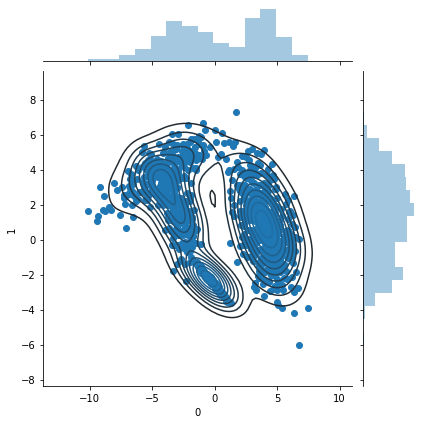

In [23]:
sns.jointplot(0, 1,data=df).plot_joint(sns.kdeplot,n_levels=10)

## simulation data

実測データは、観測値$\left\{(X_1,Y_1),(X_2,Y_2),...,(X_n,Y_n)\right\}$で表される。   
Simulatorは, 
$\theta_0 \geq x$が成り立つ条件では、$\theta_1+\theta_2 x$を出力し、   
$\theta_0 > x$が成り立つ条件では、$\theta_3+\theta_4 x$を出力する。
つまり, 入力$x$に対して、    
\begin{eqnarray}
    y = \left\{ \begin{array}{ll}
          \theta_1+\theta_2 x& (x > \theta_0) \\
          \theta_3+\theta_4 x& (x \geq \theta_0)
  \end{array} \right.
\end{eqnarray}    
に従う$y$を出力する。

SimulatorのkABCパラメタ推定は、あらかじめ$\theta$の異なる入出力データを作成する。    
$\left\{\{X^{m}_1, Y^{m}_1, \theta_m \},...,\{X^{m}_n, Y^{m}_n, \theta_m \}\right\} \, n=0,...,N \, m=0,...,M$

In [24]:
def SimModel(x,params):
    x1 = x[x>params[0]] #x > partition
    x2 = x[~(x>params[0])] # x<= partition
    y1 = params[3]+params[4]*x1 
    y2 = params[1]+params[2]*x2
    return np.r_[y2,y1]

def SimData(x):
    x_sim = x.numpy().copy()
    df = pd.DataFrame()
    for i in range(100):
        params = []
        params.append(np.random.uniform(0,10))
        params.append(np.random.uniform(0,50))
        params.append(np.random.uniform(-10,0))
        params.append(np.random.uniform(-50,0))
        params.append(np.random.uniform(0,10))
        y_sim = SimModel(x_sim, params)
        df_p = pd.DataFrame(np.c_[x_sim,y_sim, [params]*len(x_sim)],columns=['x','y']+[f'param{i}' for i in range(5)])
        df = pd.concat([df,df_p])
        
    return df

def ObsData(x):
    df = pd.DataFrame()
    x1 = x[x>5]
    x2 = x[~(x>5)]
    y1 = 2*(x1-5)
    y2 = -3*(x2-5)
    y = np.r_[y2,y1]
    df = pd.DataFrame(np.c_[x,y], columns=['x','y'])
    return df

In [25]:
x = torch.linspace(0,10,50)
df_sim = SimData(x)

In [26]:
df_sim.head()

,x,y,param0,param1,param2,param3,param4
0,0.000000,10.641638,7.547481,10.641638,-7.514077,-15.510451,4.557274
1,0.204082,9.108152,7.547481,10.641638,-7.514077,-15.510451,4.557274
2,0.408163,7.574667,7.547481,10.641638,-7.514077,-15.510451,4.557274
3,0.612245,6.041183,7.547481,10.641638,-7.514077,-15.510451,4.557274
4,0.816327,4.507697,7.547481,10.641638,-7.514077,-15.510451,4.557274


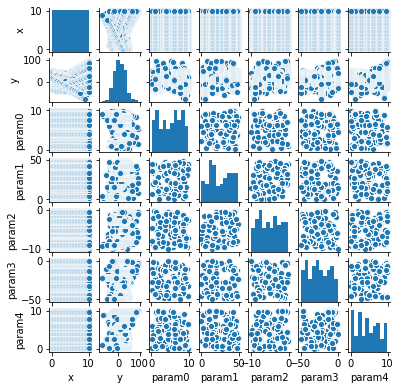

In [27]:
g=sns.pairplot(df_sim)
g.fig.set_size_inches(5,5)

In [28]:
df_obs = ObsData(x)

In [29]:
df_obs.head()

,x,y
0,0.000000,15.000000
1,0.204082,14.387755
2,0.408163,13.775511
3,0.612245,13.163265
4,0.816327,12.551020


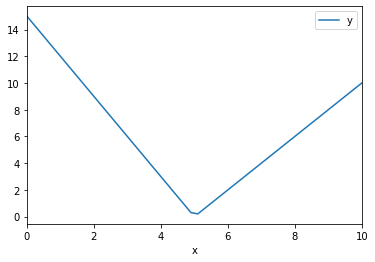

In [30]:
df_obs.plot('x','y')

In [31]:
df_sim.to_csv('./test_simulation_data.csv',index=False)
df_obs.to_csv('./test_observation_data.csv',index=False)